# Исследование объявлений о продаже квартир


## Введение 

**Краткое описание проекта**: В моём распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведём исследовательский анализ данных и установим параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

**Цель проекта**: установить, какие параметры влияют на стоимость объекта.

**Краткий план работы**:

<p><a href="#step_1"><b>Шаг 1</b></a>. Изучить общую информацию о данных.</p>
<p><a href="#step_2"><b>Шаг 2</b></a>. Выполнить предобработку данных: проверить на наличие пропусков, аномалий, дубликатов и обработать их.</p><p><a href="#step_3"><b>Шаг 3</b></a>. Дополнить датафрейм вспомогательными данными:</p>
<ul><li> цена одного квадратного метра;</li><li>день недели публикации объявления;</li><li>месяц публикации объявления;</li><li>год публикации объявления;</li><li>тип этажа квартиры (значения — «первый», «последний», «другой»);</li><li>расстояние до центра города в километрах.</li></ul>
<p><a href="#step_4"><b>Шаг 4</b></a>. Провести исследовательский анализ данных:</p>
<ol><li>изучить перечисленные ниже параметры объектов и построить отдельные гистограммы для каждого из этих параметров. Обработать аномалии в тех столбцах, где они всретятся. Список параметров:<ul><li>общая площадь;</li><li>жилая площадь;</li><li> площадь кухни;</li><li>цена объекта;</li><li>количество комнат;</li><li>высота потолков;</li><li>тип этажа квартиры («первый», «последний», «другой»);</li><li>общее количество этажей в доме;</li><li>расстояние до центра города в метрах;</li><li>расстояние до ближайшего парка.</li></ul></li>
<li>Изучить, как быстро продавались квартиры по столбцу <code>days_exposition</code>.</li>  
<li>Определить факторы, которые больше всего влияют на общую стоимость объекта.</li>  
<li>Посчитать среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.</li>   
    <li>Выделить квартиры в Санкт-Петербурге с помощью столбца <code>locality_name</code> и вычислить их среднюю стоимость на разном удалении от центра.</li>
</ol>    
<p><a href="#step_5"><b>Шаг 5</b></a>. Написать общий вывод.</p>

<a id='step_1'></a>

## Общая информация о данных

Импортируем все необходимые для выполнения работы библиотеки.

In [142]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt 

warnings.filterwarnings('ignore')

Считаем данные из csv-файла в датафрейм и сохраним в переменную `data`.

In [143]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://datasets-source-from-web/real_estate_data.csv', sep='\t')

Ознакомимся с данными:

In [144]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


**Ознакомимся с общей информацией о структуре датафрейма**

In [145]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В датафрейме содержится 22 столбца и 23 699 строк. Построим гистограмму для всех числовых столбцов. 

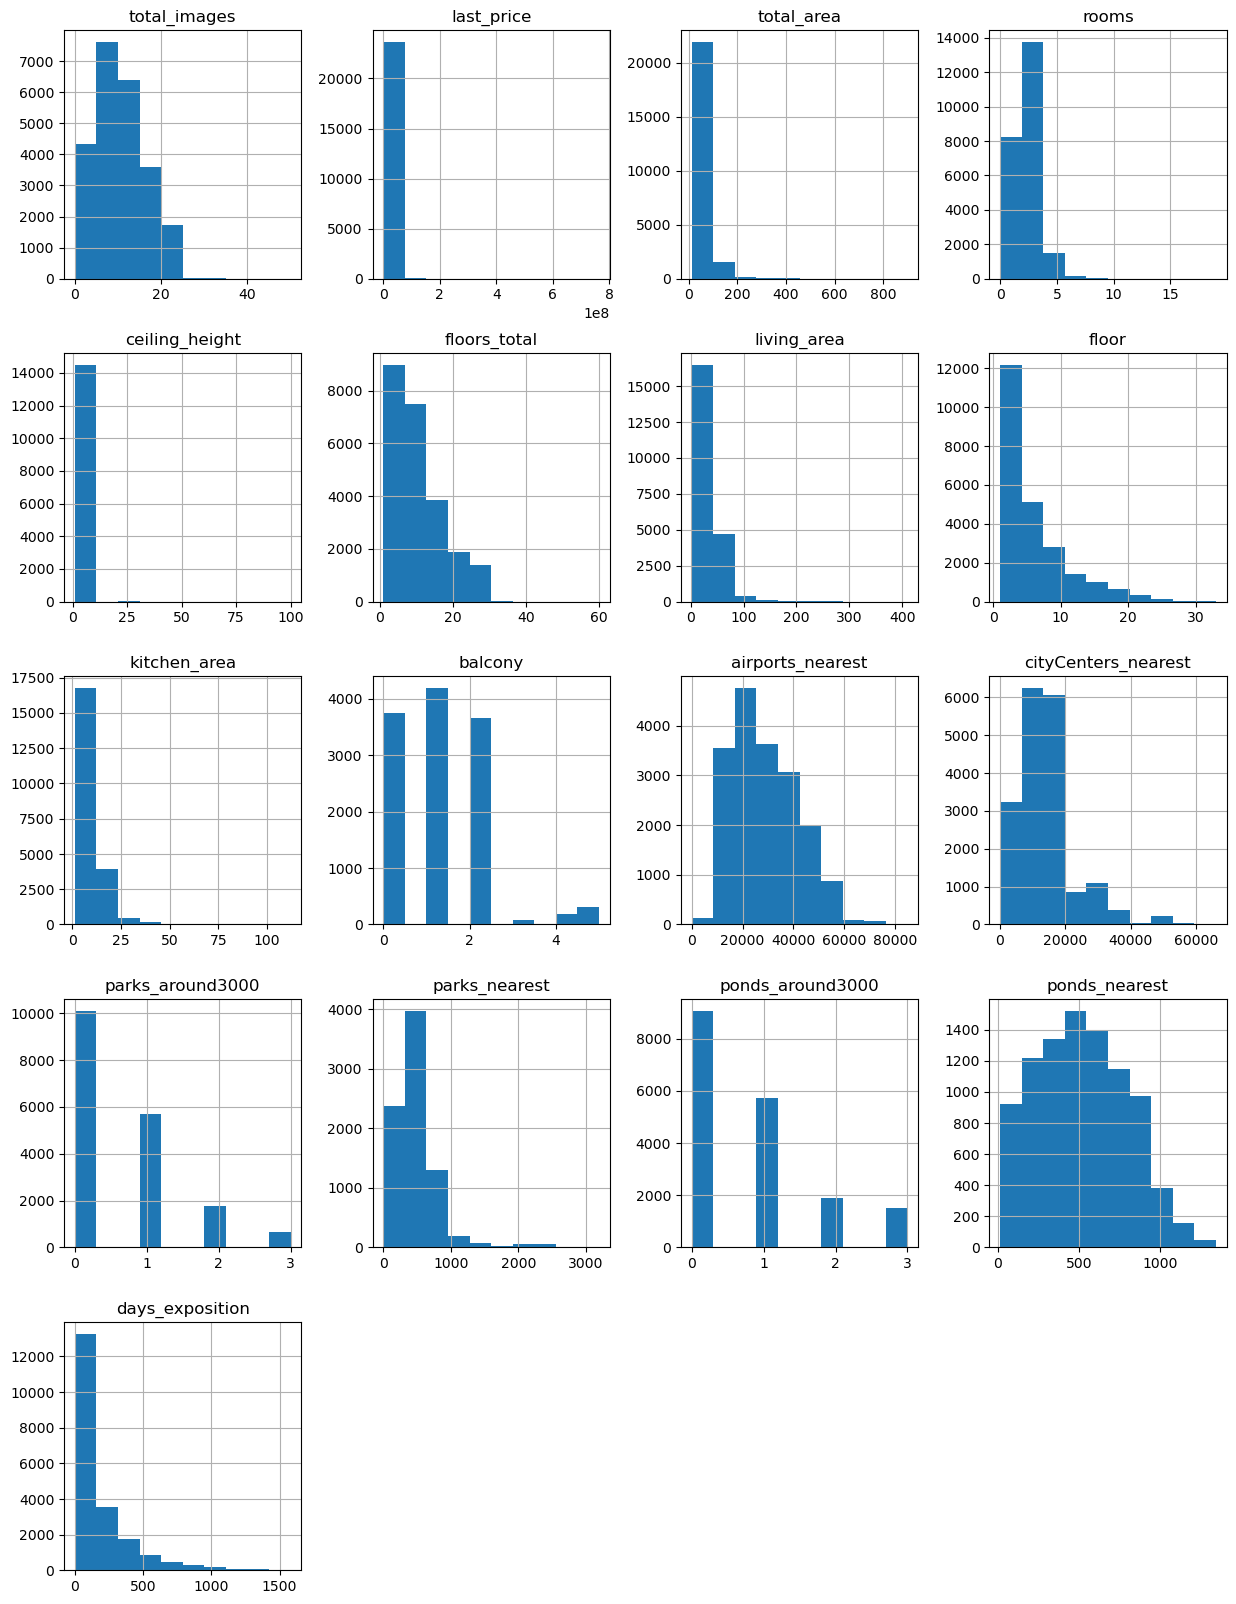

In [146]:
data.hist(figsize=(15, 20))
plt.show()

### Вывод

При изучении данных было замечено:

| Столбец | Пропущенные<br/>значения | Неверный тип данных |Комментарий|
|:----------:|:----------:|:----------:|:----------:|
| `total_images`|-|-||
| `last_price`|-|+|float64 → int64 (т.к. цены не указаны до коп.)|
| `total_area`|-|-||
| `first_day_exposition`|-|+|object → datetime|
| `rooms`|-|-||
| `ceiling_height`|+|-||
| `floors_total`|+|+|float64 → int64|
| `living_area`|+|-||
| `floor`| -|-||
| `is_apartment`|+|+|object → bool|
| `studio`|-|-||
| `open_plan`| -|-||
| `kitchen_area`|+|-||
| `balcony`|+|+|float64 → int64|
| `locality_name`|+|-||
| `airports_nearest`|+|-||
| `cityCenters_nearest`|+|-||
| `parks_around3000`|+|+|float64 → int64|
| `parks_nearest`|+|-||
| `ponds_around3000`|+|+|float64 → int64|
| `ponds_nearest`|+|-||
| `days_exposition`|+|+|float64 → int64|


<a id='step_2'></a>
## Предобработка данных

### Найдём и изучим пропущенные значения в столбцах:

Согласно результату применения метода `info()` в столбцах `ceiling_height`, `floors_total`, `living_area`, `is_apartment`, `kitchen_area`,  `balcony`, `locality_name`, `airports_nearest`, `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`,  `ponds_nearest`, `days_exposition` пристутствуют пропущенные значения. <s>Подсчитаем их количество</s> **Определим долю пропущенных зночений в каждом столбце**:

In [147]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.800000
floors_total,0.400000
living_area,8.000000
floor,0.000000
is_apartment,88.300000


Наибольшее количество пропусков, находится в столбцах  `is_apartment` (88.3%), `parks_nearest` (65.9%), `ponds_nearest` (61.6%).

<a id='section_duplicates'></a>**Проверим данные на наличие явных дубликатов**:

In [148]:
print("Количество строк-дубликатов:", data.duplicated().sum())

Количество строк-дубликатов: 0


В датафрейме не содержится явных дубликатов. Разберём по порядку каждый столбец с пропусками.

#### `ceiling_height`

`ceiling_height` &mdash; эти данные прописываются пользователем. Скорее всего при создании объявления это поле осталось незаполненным (возможно, продавец не знает высоту потолков объекта). Эти пропуски можем заполнить медианным значением для столбца `ceiling_height`.

In [149]:
data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = data['ceiling_height'].median()
print("Количество пропущенных значений в столбце ceiling_height:", data['ceiling_height'].isna().sum())

Количество пропущенных значений в столбце ceiling_height: 0


#### `floors_total`

По пропускам в столбце `floors_total` сделала предположение, что пропуски не указаны для одноэтажных домов. Проверим гипотезу, **выведя все строки с пропусками в столбце `floors_total`**.

In [150]:
data.query('floors_total.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.0,65.2,2018-10-02T00:00:00,2,2.65,NaN,30.80,4,NaN,...,12.00,NaN,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033.0,28.1,2016-11-23T00:00:00,1,2.65,NaN,20.75,1,NaN,...,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348.0,70.8,2015-08-01T00:00:00,2,2.65,NaN,38.40,12,NaN,...,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191.0,93.6,2017-04-06T00:00:00,3,2.65,NaN,47.10,8,NaN,...,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000.0,39.0,2017-04-22T00:00:00,1,2.65,NaN,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22542,5,8500000.0,63.5,2017-05-24T00:00:00,2,2.80,NaN,NaN,3,NaN,...,NaN,NaN,Санкт-Петербург,51340.0,15363.0,0.0,NaN,1.0,853.0,512.0
22656,4,4574160.0,64.5,2017-04-02T00:00:00,2,2.65,NaN,31.70,20,NaN,...,14.40,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,127.0
22808,0,14569263.0,110.4,2016-11-20T00:00:00,3,2.65,NaN,45.38,6,NaN,...,23.42,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,260.0
23590,0,21187872.0,123.3,2017-04-25T00:00:00,3,2.65,NaN,50.40,18,NaN,...,23.60,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,104.0


**Предположение не подтвердилось**: в столбце `floor` встречаются различные значения. Так как природа аномалий непонятна и доля пропущенных значений составляет менее 5%, удалим эти строик из датафрейма.

In [151]:
data = data.dropna(subset=['floors_total'])
print("Количество пропущенных значений в столбце floors_total:", data['floors_total'].isna().sum())

Количество пропущенных значений в столбце floors_total: 0


#### `living_area`

Заполним пропуски в этом столбце медианным значением с группировкой по числу комнат в квартире.


In [152]:
for r in data['rooms'].unique():
    data.loc[(data['rooms'] == r) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['rooms'] == r), 'living_area'].median()

#проверим, что пропусков в столбце больше нет
print("Количество пропущенных значений в столбце living_area:", data['living_area'].isna().sum())       

Количество пропущенных значений в столбце living_area: 0


#### `is_apartment`

Это значение должно иметь булев тип (`True` или `False`). Статус объекта &mdash; важная информация, поэтому будем считать, что если объект не определён однозначно как апартаменты, то он таковым не является. **Пропуски в этом столбце заполним булевым значением `False`**. 

In [153]:
data['is_apartment'] = data['is_apartment'].fillna(value = False)
print("Количество пропущенных значений в столбце is_apartment:", data['is_apartment'].isna().sum()) #проверим, что пропусков в столбце больше нет

Количество пропущенных значений в столбце is_apartment: 0


#### `kitchen_area`

По аналогии с `living_area` **заполним пропуски медианным значением столбца с группировкой по количеству комнат**:

In [154]:
for room in data['rooms'].unique():
    data.loc[(data['rooms'] == room) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
    data.loc[(data['rooms'] == room), 'kitchen_area'].median()

#проверим, что пропусков в столбце больше нет
print("Количество пропущенных значений в столбце kitchen_area:", data['kitchen_area'].isna().sum())     

Количество пропущенных значений в столбце kitchen_area: 194


**В столбце остались пропуски**. Чтобы разобраться, в чём проблема, выведем строки с пропусками в столбце `kitchen_area`.

In [155]:
data.query('kitchen_area.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
144,1,2450000.0,27.00,2017-03-30T00:00:00,0,2.65,24.0,15.50,2,False,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,181.0
349,4,2320000.0,25.00,2017-09-27T00:00:00,0,2.65,14.0,17.00,1,False,...,NaN,0.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.0
440,8,2480000.0,27.11,2018-03-12T00:00:00,0,2.65,17.0,24.75,4,False,...,NaN,2.0,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0
508,0,3375000.0,34.40,2017-03-28T00:00:00,0,2.65,26.0,24.30,19,False,...,NaN,1.0,посёлок Парголово,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0
608,2,1850000.0,25.00,2019-02-20T00:00:00,0,2.65,10.0,18.00,7,False,...,NaN,NaN,посёлок Шушары,NaN,NaN,NaN,NaN,NaN,NaN,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000.0,26.00,2017-09-01T00:00:00,0,2.65,25.0,18.00,16,False,...,NaN,0.0,Санкт-Петербург,11405.0,13222.0,0.0,NaN,1.0,623.0,14.0
23442,0,2500000.0,27.70,2017-09-28T00:00:00,0,2.65,24.0,18.00,4,False,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,4.0
23554,15,3350000.0,26.00,2018-09-07T00:00:00,0,2.65,19.0,18.00,8,False,...,NaN,NaN,Санкт-Петербург,18090.0,17092.0,0.0,NaN,2.0,112.0,31.0
23592,10,1450000.0,29.00,2017-11-11T00:00:00,0,2.65,9.0,18.00,8,False,...,NaN,2.0,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,82.0


Похоже, проблема в объектах со значениями `0` в столбце `rooms`. 0 комнат может быть в квартирах с открытой планировкой и в студиях. Проверим гипотезу:

In [156]:
print("Количество объектов-студий:", len(data.query('studio==True')))
print("Из них с пропуском в столбце kitchen_area:", len(data.query('(studio==True) and (kitchen_area.isna())')))
print("Количество объектов с открытой планировкой:", len(data.query('open_plan==True')))
print("Из них с пропуском в столбце kitchen_area:", len(data.query('(open_plan==True) and (kitchen_area.isna())')))

#проверим, что множества объектов студий и объектов с открытой планировкой не пересекаются:
print("Количество объектов-студий с открытой планировкой:", len(data.query('(open_plan==True) and (studio==True)')))

#проверим, есть ли строки с пропуском в столбце kitchen_area, и при этом значение в столбце rooms != 0:
print("Количество объектов c пропуском в столбце kitchen_area и rooms != 0:", len(data.query('(kitchen_area.isna()) and (rooms!=0)')))

Количество объектов-студий: 146
Из них с пропуском в столбце kitchen_area: 135
Количество объектов с открытой планировкой: 67
Из них с пропуском в столбце kitchen_area: 59
Количество объектов-студий с открытой планировкой: 0
Количество объектов c пропуском в столбце kitchen_area и rooms != 0: 0


Гипотеза подтверждена. Однако можем заметить, что не все студии и не все объекты с открытой планировкой имеют пропуски в столбце `kitchen_area`. Вычислим медианные значения площадей кухонь для студий и для квартир с открытой планировкой, после чего заполним ими пропуски в столбце `kitchen_area`.

In [157]:
data.loc[(data['studio'] == True) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
data.loc[(data['studio'] == True), 'kitchen_area'].median()

data.loc[(data['open_plan'] == True) & (data['kitchen_area'].isna()), 'kitchen_area'] = \
data.loc[(data['open_plan'] == True), 'kitchen_area'].median()

#проверим, что пропусков в столбце больше нет
print("Количество пропущенных значений в столбце kitchen_area:", data['kitchen_area'].isna().sum())     

Количество пропущенных значений в столбце kitchen_area: 0


**К значению `0` в столбце `rooms` дополнительно вернёмся на шаге обработки аномалий.**

#### `locality_name`

Выведем строки с пропущенными значениями в `locality_name`.

In [158]:
data.query('locality_name.isna()').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1097,3,8600000.0,81.7,2016-04-15T00:00:00,3,3.55,5.0,50.8,2,False,...,8.8,0.0,NaN,23478.0,4258.0,0.0,NaN,0.0,NaN,147.0
2033,6,5398000.0,80.0,2017-05-30T00:00:00,3,2.65,4.0,42.6,2,False,...,18.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0
2603,20,3351765.0,42.7,2015-09-20T00:00:00,1,2.65,24.0,15.6,3,False,...,10.7,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,276.0
2632,2,5130593.0,62.4,2015-10-11T00:00:00,2,2.65,24.0,33.1,21,False,...,8.2,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,256.0
3574,10,4200000.0,46.5,2016-05-28T00:00:00,2,2.65,5.0,30.8,5,False,...,6.5,0.0,NaN,27419.0,8127.0,0.0,NaN,1.0,603.0,45.0


По срезу данных нельзя назвать точную причину отсутствия значения. Так как природа аномалий непонятна и доля пропущенных значений составляет менее 5%, **удалим эти строки из датафрейма**.

In [159]:
data = data.dropna(subset=['locality_name'])
print("Количество пропущенных значений в столбце locality_name:", data['locality_name'].isna().sum())

Количество пропущенных значений в столбце locality_name: 0


#### `balcony` 

Если продавец не указал число балконов, то, скорее всего, в его квартире их нет. **Такие пропуски можно заменить на число `0`**.

In [160]:
data['balcony'] = data['balcony'].fillna(value = 0)
#проверим, что пропусков в столбце больше нет
print("Количество пропущенных значений в столбце balcony:", data['balcony'].isna().sum()) 

Количество пропущенных значений в столбце balcony: 0


Чтобы корректно заполнить пропущенные значения в `airports_nearest`и `cityCenters_nearest`, нужно избавиться от неявных дубликатов в столбце `locality_name`.

In [161]:
print(data['locality_name'].sort_values().unique())
print("Всего уникальных наименований в `locality_name`:", len(data['locality_name'].sort_values().unique())) 

['Бокситогорск' 'Волосово' 'Волхов' 'Всеволожск' 'Выборг' 'Высоцк'
 'Гатчина' 'Зеленогорск' 'Ивангород' 'Каменногорск' 'Кингисепп' 'Кириши'
 'Кировск' 'Колпино' 'Коммунар' 'Красное Село' 'Кронштадт' 'Кудрово'
 'Лодейное Поле' 'Ломоносов' 'Луга' 'Любань' 'Мурино' 'Никольское'
 'Новая Ладога' 'Отрадное' 'Павловск' 'Петергоф' 'Пикалёво' 'Подпорожье'
 'Приморск' 'Приозерск' 'Пушкин' 'Санкт-Петербург' 'Светогорск'
 'Сертолово' 'Сестрорецк' 'Сланцы' 'Сосновый Бор' 'Сясьстрой' 'Тихвин'
 'Тосно' 'Шлиссельбург' 'городской поселок Большая Ижора'
 'городской поселок Янино-1' 'городской посёлок Будогощь'
 'городской посёлок Виллози' 'городской посёлок Лесогорский'
 'городской посёлок Мга' 'городской посёлок Назия'
 'городской посёлок Новоселье' 'городской посёлок Павлово'
 'городской посёлок Рощино' 'городской посёлок Свирьстрой'
 'городской посёлок Советский' 'городской посёлок Фёдоровское'
 'городской посёлок Янино-1' 'деревня Агалатово' 'деревня Аро'
 'деревня Батово' 'деревня Бегуницы' 'деревн

Найдено много неявных дубликатов, получившихся в результате разных написаний населённых пунктов типа &laquo;посёлок&raquo;. Заменим все разномастные &laquo;посёлки&raquo; на &laquo;поселки&raquo;.

In [162]:
data = data.apply(lambda x: x.replace({'поселок':'посёлок', 
                                       'городской посёлок': 'посёлок', 
                                       'посёлок городского типа': 'посёлок', 
                                       'коттеджный посёлок': 'посёлок', 
                                       'посёлок при железнодорожной станции': 'посёлок станции'}, regex=True))


print(data['locality_name'].sort_values().unique())
print("Всего уникальных наименований в `locality_name`:", len(data.locality_name.unique())) 

['Бокситогорск' 'Волосово' 'Волхов' 'Всеволожск' 'Выборг' 'Высоцк'
 'Гатчина' 'Зеленогорск' 'Ивангород' 'Каменногорск' 'Кингисепп' 'Кириши'
 'Кировск' 'Колпино' 'Коммунар' 'Красное Село' 'Кронштадт' 'Кудрово'
 'Лодейное Поле' 'Ломоносов' 'Луга' 'Любань' 'Мурино' 'Никольское'
 'Новая Ладога' 'Отрадное' 'Павловск' 'Петергоф' 'Пикалёво' 'Подпорожье'
 'Приморск' 'Приозерск' 'Пушкин' 'Санкт-Петербург' 'Светогорск'
 'Сертолово' 'Сестрорецк' 'Сланцы' 'Сосновый Бор' 'Сясьстрой' 'Тихвин'
 'Тосно' 'Шлиссельбург' 'городской посёлок Большая Ижора'
 'городской посёлок Янино-1' 'деревня Агалатово' 'деревня Аро'
 'деревня Батово' 'деревня Бегуницы' 'деревня Белогорка'
 'деревня Большая Вруда' 'деревня Большая Пустомержа'
 'деревня Большие Колпаны' 'деревня Большое Рейзино'
 'деревня Большой Сабск' 'деревня Бор' 'деревня Борисова Грива'
 'деревня Ваганово' 'деревня Вартемяги' 'деревня Вахнова Кара'
 'деревня Выскатка' 'деревня Гарболово' 'деревня Глинка'
 'деревня Горбунки' 'деревня Гостилицы' 'деревн

#### `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`

Данные для этих столбцов собираются автоматически: скорее всего некорректно отработали методы, которые возвращают растояния до аэропорта/центра города/парка/водоёма. Пропуски в этих столбцах **требуют внимания разработки**.

#### `days_exposition`

Предполагаю, что в тех строках, где допущены пропуски, объявление не прошло модерацию и не было опубликовано. Пропущенные значения в этом столбце заполним нулями.

In [163]:
data['days_exposition'] = data['days_exposition'].fillna(value = 0)
print("Количество пропущенных значений в столбце days_exposition:", data['days_exposition'].isna().sum()) #проверим, что пропусков в столбце больше нет

Количество пропущенных значений в столбце days_exposition: 0


### Корректировка типов данных

Вернёмся к общей информации о датафрейме:

In [164]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment               bool
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

В коррекции нуждаются следующие столбцы:  
`last_price`: float64 -> int64 (в датафрейме отсутствуют цены с точностью до коп.)   
`floors_total`: float64 -> int64 (в доме может быть только целое количество этажей)  
`balcony`: float64 -> int64 (так как в доме может быть только целое количество балконов)  
`days_exposition`: float64 -> int64 (для последующей обработки) 

In [165]:
data['first_day_exposition']

0        2019-03-07T00:00:00
1        2018-12-04T00:00:00
2        2015-08-20T00:00:00
3        2015-07-24T00:00:00
4        2018-06-19T00:00:00
                ...         
23694    2017-03-21T00:00:00
23695    2018-01-15T00:00:00
23696    2018-02-11T00:00:00
23697    2017-03-28T00:00:00
23698    2017-07-21T00:00:00
Name: first_day_exposition, Length: 23565, dtype: object

In [166]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])
data[['last_price', 'balcony', 'floors_total', 'days_exposition']] = \
data[['last_price', 'balcony', 'floors_total', 'days_exposition']].astype(int)
#проверим, что изменения применились
data.dtypes

total_images                     int64
last_price                       int64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                  int64
dtype: object

### Вывод

In [167]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  int64         
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony              

In [168]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,0.000000
floors_total,0.000000
living_area,0.000000
floor,0.000000
is_apartment,0.000000


**1. Устранены пропуски в столбцах**:
- `ceiling_height` — заполнено медианным значением;
- `living_area` — заполнено медианным значением с группировкой по количеству комнат объекта; 
- `is_apartment` — заполнено False; 
- `kitchen_area` — заполнено медианным значением с группировкой по количеству комнат объекта;  
- `balcony` — заполнено 0; 
- `days_exposition` — заполнено 0; 

Пропущенные значения в столбцах `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `ponds_around3000`, `ponds_nearest`, `parks_nearest`  не были устранены (эти данные заполняются автоматически).

**2. Устранены неявные дубликаты в столбце `locality_name`** (число уникальных значений снизилось с 364 до 318)

**3. Скорректированы типы данных для столбцов:**  
`last_price`: float64 -> int64  
`first_day_exposition`: object -> date_time  
`balcony`: float64 -> int64  
`float_total`: float64 -> int64   
`days_exposition`: float64 -> int64 

**4.  Проверено, что в датафрейме отстутствуют явные дубиликаты**

<a id='step_3'></a>
## Добавление в таблицу новых столбцов

Для дальнейшего исследования добавим новые столбцы в датафрейм.

1. цена одного квадратного метра;
2. день недели публикации объявления;
3. месяц публикации объявления;
4. год публикации объявления;
5. тип этажа квартиры;
6. расстояние до центра города в километрах.

### Цена одного квадратного метра (`one_sq_meter_price`)

In [169]:
data['one_sq_meter_price'] = round(data['last_price'] / data['total_area'], 2)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,one_sq_meter_price
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,0,120370.37
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81,82920.79
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558,92785.71
3,0,64900000,159.0,2015-07-24,3,2.65,14,45.0,9,False,...,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424,408176.10
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121,100000.00


### День, месяц, год публикации объявления (`first_day_exposition_week_day`, `first_day_exposition_month`, `first_day_exposition_year`)

In [170]:
data['first_day_exposition_week_day'] = data['first_day_exposition'].dt.weekday
data['first_day_exposition_month'] = data['first_day_exposition'].to_numpy().astype('datetime64[M]')
data['first_day_exposition_year'] = pd.DatetimeIndex(data['first_day_exposition']).year
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,one_sq_meter_price,first_day_exposition_week_day,first_day_exposition_month,first_day_exposition_year
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,16028.0,1.0,482.0,2.0,755.0,0,120370.37,3,2019-03-01,2019
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,18603.0,0.0,NaN,0.0,NaN,81,82920.79,1,2018-12-01,2018
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,13933.0,1.0,90.0,2.0,574.0,558,92785.71,3,2015-08-01,2015
3,0,64900000,159.0,2015-07-24,3,2.65,14,45.0,9,False,...,6800.0,2.0,84.0,3.0,234.0,424,408176.10,4,2015-07-01,2015
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,8098.0,2.0,112.0,1.0,48.0,121,100000.00,1,2018-06-01,2018


### Тип этажа квартиры: «первый», «последний», «другой» (`floor_type`)

In [171]:
def find_floor_type(row):
    """
    Возвращает тип этажа квартиры по значению этажа floor, используя правила:
    - 'первый', если floor = 1;
    - 'последний', если floor = floors_total;
    - 'другой' — 1 < floor < floor_total.
    """
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

In [172]:
data['floor_type'] = data.apply(find_floor_type, axis=1)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,one_sq_meter_price,first_day_exposition_week_day,first_day_exposition_month,first_day_exposition_year,floor_type
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,1.0,482.0,2.0,755.0,0,120370.37,3,2019-03-01,2019,другой
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,0.0,NaN,0.0,NaN,81,82920.79,1,2018-12-01,2018,первый
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,1.0,90.0,2.0,574.0,558,92785.71,3,2015-08-01,2015,другой
3,0,64900000,159.0,2015-07-24,3,2.65,14,45.0,9,False,...,2.0,84.0,3.0,234.0,424,408176.10,4,2015-07-01,2015,другой
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,2.0,112.0,1.0,48.0,121,100000.00,1,2018-06-01,2018,другой


### Расстояние до центра города в километрах (`cityCenters_nearest_km`)

In [173]:
data['cityCenters_nearest_km'] = round((data['cityCenters_nearest'] / 1000))
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,one_sq_meter_price,first_day_exposition_week_day,first_day_exposition_month,first_day_exposition_year,floor_type,cityCenters_nearest_km
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482.0,2.0,755.0,0,120370.37,3,2019-03-01,2019,другой,16.0
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,NaN,0.0,NaN,81,82920.79,1,2018-12-01,2018,первый,19.0
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,90.0,2.0,574.0,558,92785.71,3,2015-08-01,2015,другой,14.0
3,0,64900000,159.0,2015-07-24,3,2.65,14,45.0,9,False,...,84.0,3.0,234.0,424,408176.10,4,2015-07-01,2015,другой,7.0
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,112.0,1.0,48.0,121,100000.00,1,2018-06-01,2018,другой,8.0


<a id='step_4'></a>
### Исследовательский анализ данных

#### Обработка аномальных значений 

Проведём исследование следующих параметров объявления:  

- `общая площадь`;
- `жилая площадь`;
- `площадь кухни`;
- `цена объекта`;
- `количество комнат`;
- `высота потолков`;
- `тип этажа квартиры («первый», «последний», «другой»)`;
- `общее количество этажей в доме`;
- `расстояние до центра города в метрах`;
- `расстояние до ближайшего парка`

##### Общая площадь (`total_area`)

In [174]:
data['total_area'].describe()

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

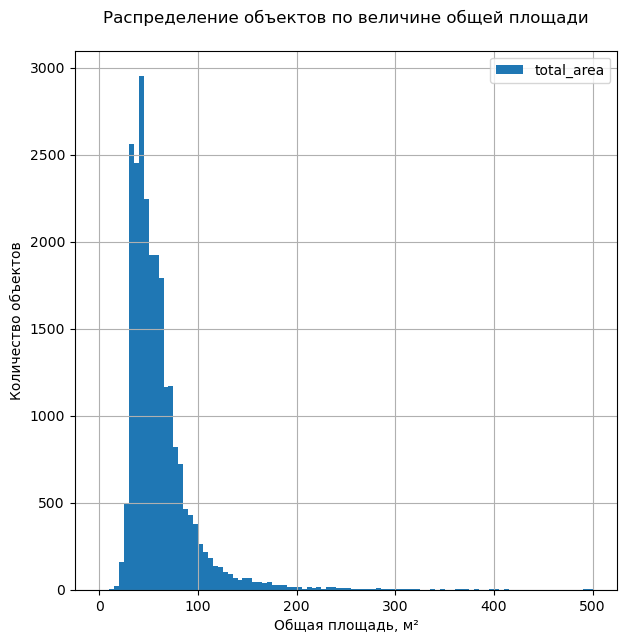

In [175]:
data.plot(y = 'total_area', kind = 'hist', bins = 100, grid=True, figsize = (7,7), range = (0,500))
plt.xlabel("Общая площадь, м²")
plt.ylabel("Количество объектов")
plt.title("Распределение объектов по величине общей площади", pad='20.0');

Гистограмма соответствует нормальному распределению. Минимальная площадь объекта из выборки &mdash; 12 м<sup>2</sup>, максимальная &mdash; 900 м<sup>2</sup>. Средняя общая площадь квартиры составляет 60 м<sup>2</sup>, а медианное значение равно 52 м<sup>2</sup>. Объекты с большей площадью относятся к более дорогому сегменту &mdash; таких предложений на рынке недвижимости меньше.

Определим границцы нормального распределения с помощью диаграммы размаха:

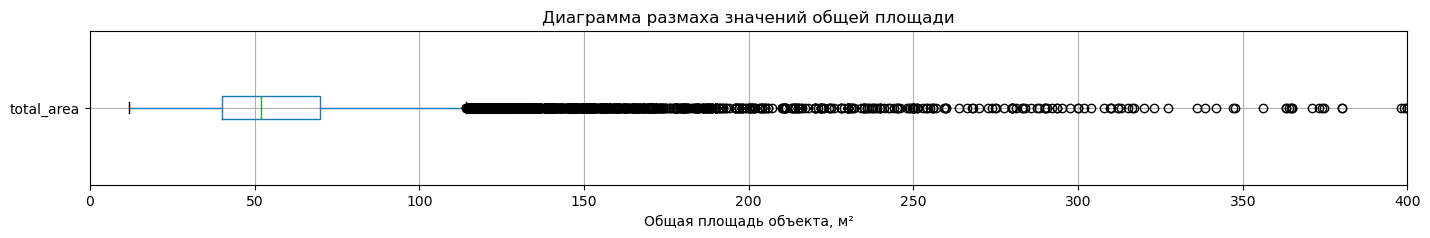

In [176]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['total_area']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха значений общей площади')
ax.set_xlim(0, 400)
plt.xlabel("Общая площадь объекта, м²");

Нормальные значения общей площади объекта лежат в интервале от 12 до 115 м<sup>2</sup>. Отсеим все выбросы из датафрейма:

In [177]:
data = data.query('total_area < 115')

**Вывод**: гистограмма соответствует нормальному распределению. Наибольшее количество объектов, представленных на рынке, имеют общую площадь ~45 м<sup>2</sup> (пик), слева и справа от пика гистограмма стремится к нулю. Было установлено, что нормальные значения площади находятся в интервале между 12 м<sup>2</sup> (min) и 115 м<sup>2</sup> (определено с помощью диаграммы размаха). Значения, попавшие в этот промежуток были отсеяны как аномальные.

##### Жилая площадь (`living_area`)

По аналогии с `total_area` проведём анализ столбца, содержащего значения жилой площади объекта:

In [178]:
data['living_area'].describe()

count    22336.000000
mean        31.025767
std         13.491990
min          2.000000
25%         18.000000
50%         30.000000
75%         40.000000
max        145.000000
Name: living_area, dtype: float64

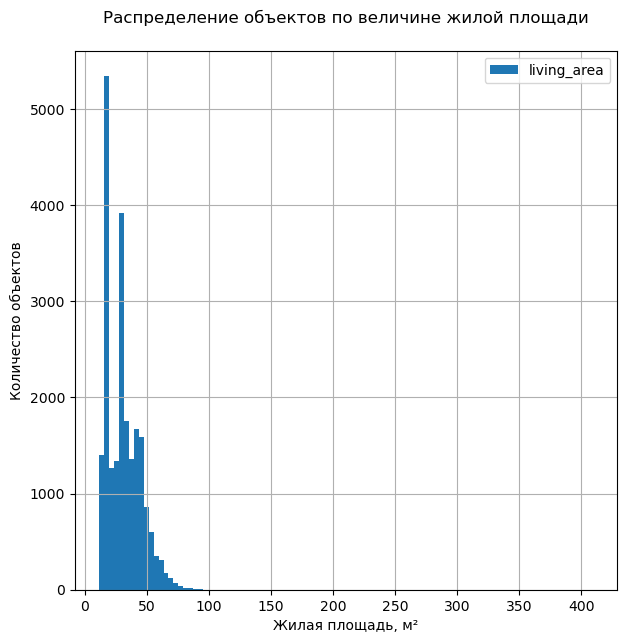

In [179]:
data.plot(y = 'living_area', kind = 'hist', bins = 100, grid=True, figsize = (7,7), range = (12,409))
plt.xlabel("Жилая площадь, м²")
plt.ylabel("Количество объектов")
plt.title("Распределение объектов по величине жилой площади", pad='20.0');

Минимальное значение жилой площади составляет 2 м<sup>2</sup>. Даже для студии 12 м<sup>2</sup> это мало. Выведем все строки, для которых жилая площадь меньше 10 м<sup>2</sup>.

In [180]:
data.query('living_area<10')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,one_sq_meter_price,first_day_exposition_week_day,first_day_exposition_month,first_day_exposition_year,floor_type,cityCenters_nearest_km
114,5,4000000,21.40,2019-02-07,1,2.90,8,8.3,7,False,...,488.0,1.0,286.0,0,186915.89,3,2019-02-01,2019,другой,6.0
680,14,7200000,43.00,2017-10-31,1,2.65,8,9.0,2,False,...,2137.0,1.0,933.0,296,167441.86,1,2017-10-01,2017,другой,5.0
1326,8,8100000,52.00,2017-01-29,2,2.70,25,9.0,15,False,...,NaN,1.0,1180.0,337,155769.23,6,2017-01-01,2017,другой,16.0
2309,10,4200000,62.40,2017-06-15,2,2.60,9,8.4,6,False,...,NaN,0.0,NaN,111,67307.69,3,2017-06-01,2017,другой,29.0
3242,7,4440000,41.00,2017-07-02,1,2.65,17,3.0,17,False,...,NaN,0.0,NaN,216,108292.68,6,2017-07-01,2017,последний,13.0
4100,17,5300000,34.80,2017-06-19,1,2.70,23,9.0,15,False,...,NaN,0.0,NaN,30,152298.85,0,2017-06-01,2017,другой,13.0
4542,12,3300000,18.00,2018-11-07,1,3.50,5,9.0,2,False,...,349.0,1.0,963.0,9,183333.33,2,2018-11-01,2018,другой,5.0
7312,8,3400000,27.00,2018-02-21,2,2.50,15,9.0,4,False,...,617.0,0.0,NaN,0,125925.93,2,2018-02-01,2018,другой,16.0
8325,9,4800000,52.00,2017-10-25,2,2.65,5,9.0,2,False,...,NaN,2.0,118.0,119,92307.69,2,2017-10-01,2017,другой,13.0
13915,20,6350000,52.00,2018-02-06,2,3.00,6,2.0,2,False,...,NaN,1.0,1012.0,91,122115.38,1,2018-02-01,2018,другой,7.0


Достаточно много строк выглядят подозрительно (например id 3242: объект площадью 41.00 м<sup>2</sup> и жилой площадью 3 м<sup>2</sup>. Вычислим, какую долю от общей площади составляет жилая площадь для каждого объявления:

In [181]:
data['living_area_share'] = data['living_area']/data['total_area']

#Соберём данные в сводную талицу, где строки — количество комнат объекта,
#столбцы — медиана, среднее, мнимальное, максимальное значение доли жилой площади
data_pivot_table = data.pivot_table(index='rooms', values='living_area_share', aggfunc=['median', 'mean','min', 'max','count'])
data_pivot_table.columns = ['median', 'mean','min', 'max','count']
data_pivot_table

,median,mean,min,max,count
rooms,,,,,
0,0.689655,0.686726,0.086957,1.000000,193
1,0.481690,0.485991,0.073171,1.353846,7999
2,0.584906,0.579374,0.038462,1.016667,7860
3,0.634921,0.632778,0.141304,1.097561,5414
4,0.682141,0.683896,0.069588,1.511905,788
5,0.690661,0.717692,0.417910,1.369925,73
6,0.785541,0.833113,0.660377,1.173585,8
7,1.441352,1.441352,1.441352,1.441352,1


По сводной таблице можно увидеть, что проблема достаточно масштабная. Есть строки, где доля жилой площади стремится к нулю, а также строки, где жилая площадь превышает общую. Найдём все строки, для которых доля жилой площади меньше половины медианы и больше 1.5 медиан.

In [182]:
data =  data.merge(data_pivot_table['median'], on='rooms')
data.query('(living_area_share > median*1.5) or (living_area_share > 1) or (living_area_share < median*0.5)')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,one_sq_meter_price,first_day_exposition_week_day,first_day_exposition_month,first_day_exposition_year,floor_type,cityCenters_nearest_km,living_area_share,median
54,13,2200000,47.0,2018-01-12,3,2.34,5,45.000,1,False,...,NaN,45,46808.51,4,2018-01-01,2018,первый,NaN,0.957447,0.634921
774,18,3650000,41.5,2018-02-14,3,2.50,5,45.000,3,False,...,745.0,24,87951.81,2,2018-02-01,2018,другой,11.0,1.084337,0.634921
907,4,2600000,70.4,2017-07-29,3,2.50,5,68.100,5,False,...,NaN,45,36931.82,5,2017-07-01,2017,последний,NaN,0.967330,0.634921
1011,19,6900000,72.0,2019-03-25,3,3.50,4,70.000,1,True,...,439.0,22,95833.33,0,2019-03-01,2019,первый,4.0,0.972222,0.634921
1102,8,6550000,81.5,2018-10-14,3,2.65,6,22.500,3,False,...,NaN,34,80368.10,6,2018-10-01,2018,другой,NaN,0.276074,0.634921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22237,0,2330000,23.0,2018-01-01,0,2.65,24,2.000,22,False,...,NaN,66,101304.35,0,2018-01-01,2018,другой,NaN,0.086957,0.689655
22288,1,4900000,71.4,2017-09-21,5,2.60,9,91.785,7,False,...,NaN,133,68627.45,3,2017-09-01,2017,другой,15.0,1.285504,0.690661
22290,7,5250000,67.0,2018-02-16,5,2.50,5,91.785,1,False,...,568.0,81,78358.21,4,2018-02-01,2018,первый,10.0,1.369925,0.690661
22332,11,12990000,106.0,2018-07-08,6,2.65,4,124.400,1,False,...,361.0,90,122547.17,6,2018-07-01,2018,первый,4.0,1.173585,0.785541


Найдено **269 строк с очень маленькой и с очень большой жилой площадью**. Удалим их из основного датафрейма.

In [183]:
data = data.query('~((living_area_share > median*1.5) or (living_area_share > 1) or (living_area_share < median*0.5))')

Проведём повторное исследование столбца:

In [184]:
data['living_area'].describe()

count    22067.000000
mean        31.071385
std         13.422673
min          8.300000
25%         18.000000
50%         30.000000
75%         40.200000
max        101.000000
Name: living_area, dtype: float64

**Вывод**: гистограмма не соответствует нормальному распределению. Минимальное значение жилой площади из выборки &mdash; 8.3 м<sup>2</sup>. Максимальное &mdash; 101 м<sup>2</sup>. Среднее значение жилой площади составляет 31 м<sup>2</sup>, а медианное &mdash; 30 м<sup>2</sup>. На гистограмме хорошо видны 3 пика: первый &mdash; в первом квартиле, второй &mdash; в медиане,  третий &mdash; в третьем квартиле. Принимая во внимание, что средняя площадь одной комнаты в России составляет 14-18 м<sup>2</sup>, эти пики соответствуют однокомнатным, двухкомнатным и трёхкомнатным квартирам.

##### Пощадь кухни `kitchen_area`

In [185]:
data['kitchen_area'].describe()

count    22067.000000
mean         9.784558
std          4.012858
min          1.300000
25%          7.100000
50%          9.000000
75%         11.000000
max         55.700000
Name: kitchen_area, dtype: float64

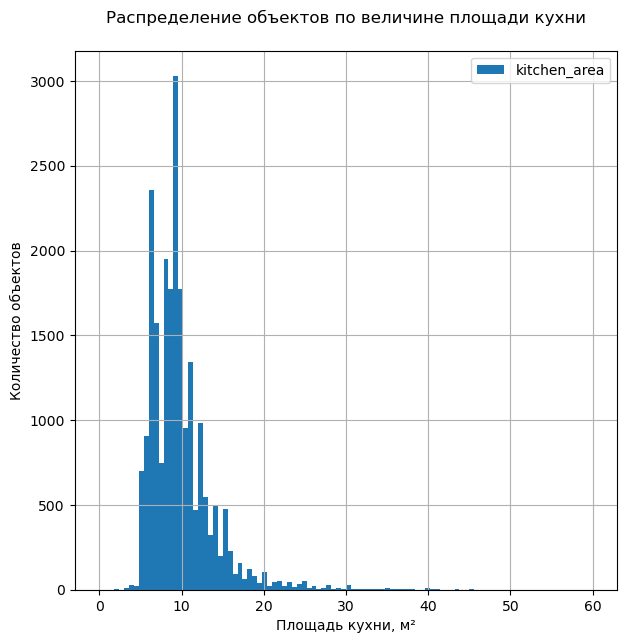

In [186]:
data.plot(y = 'kitchen_area', kind = 'hist', bins = 100, grid=True, figsize = (7,7), range = (0,60))
plt.xlabel("Площадь кухни, м²")
plt.ylabel("Количество объектов")
plt.title("Распределение объектов по величине площади кухни", pad='20.0');

Минимальное значение площади кухни в выборке &mdash; 1.3 м<sup>2</sup>, что в 4 раза меньше минимально допустимой площади в 5 м<sup>2</sup> (это по самому [минимуму](https://apb1.ru/minimalnaya-ploshchad-zhilyh-komnat.html#:~:text=%D0%9D%D0%B0%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80%2C%20%D0%BA%D1%83%D1%85%D0%BD%D1%8F%20%D0%B4%D0%BE%D0%BB%D0%B6%D0%BD%D0%B0%20%D0%B8%D0%BC%D0%B5%D1%82%D1%8C%20%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C,%D0%BD%D0%B5%20%D0%BC%D0%B5%D0%BD%D0%B5%D0%B5%20%D0%BF%D1%8F%D1%82%D0%B8%20%C2%AB%D0%BA%D0%B2%D0%B0%D0%B4%D1%80%D0%B0%D1%82%D0%BE%D0%B2%C2%BB.) для кухни-ниши). Найдём все объекты с площадью кухни меньше 5 м<sup>2</sup>.

In [187]:
data.query('kitchen_area<5')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,one_sq_meter_price,first_day_exposition_week_day,first_day_exposition_month,first_day_exposition_year,floor_type,cityCenters_nearest_km,living_area_share,median
14,12,2800000,55.1,2016-05-14,3,2.60,5,38.4,1,False,...,NaN,606,50816.70,5,2016-05-01,2016,первый,NaN,0.696915,0.634921
96,8,1700000,55.2,2018-03-24,3,2.50,5,38.5,5,False,...,NaN,0,30797.10,5,2018-03-01,2018,последний,NaN,0.697464,0.634921
553,11,4900000,55.2,2019-04-18,3,2.50,5,40.5,3,False,...,NaN,0,88768.12,3,2019-04-01,2019,другой,13.0,0.733696,0.634921
705,0,3900000,52.0,2017-12-06,3,2.65,5,38.0,5,False,...,336.0,9,75000.00,2,2017-12-01,2017,последний,50.0,0.730769,0.634921
1224,16,8200000,60.0,2015-12-16,3,2.65,12,38.7,3,False,...,NaN,184,136666.67,2,2015-12-01,2015,другой,11.0,0.645000,0.634921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20943,9,2600000,42.4,2017-08-18,2,2.50,5,27.6,5,False,...,NaN,116,61320.75,4,2017-08-01,2017,последний,NaN,0.650943,0.584906
21078,1,2900000,34.0,2018-02-01,2,2.90,2,20.0,1,False,...,872.0,196,85294.12,3,2018-02-01,2018,первый,24.0,0.588235,0.584906
21213,7,1600000,54.0,2016-12-26,2,2.30,1,33.0,1,False,...,NaN,281,29629.63,0,2016-12-01,2016,первый,NaN,0.611111,0.584906
21267,10,3500000,43.0,2016-05-19,2,2.50,3,26.1,2,False,...,1134.0,252,81395.35,3,2016-05-01,2016,другой,28.0,0.606977,0.584906


В таблице можно обнаружить объекты площадью более 40 м<sup>2</sup> с непропорционально маленькими кухнями. Эти данные будем считать аномальными и **удалим из датафрейма**. 

In [188]:
data = data.query('kitchen_area>=5')

In [189]:
data['kitchen_area'].describe()

count    21974.000000
mean         9.808667
std          4.003821
min          5.000000
25%          7.100000
50%          9.000000
75%         11.000000
max         55.700000
Name: kitchen_area, dtype: float64

**Вывод**: минимальная площадь кухни составляет 5 м<sup>2</sup>, максимальная &mdash; 55.7 м<sup>2</sup>. Cреднее значение площадь состовляет 9.8 м<sup>2</sup>, а медианное &mdash; 9 м<sup>2</sup>, здесь же на гистограмме находится пиковое значение. (9 м<sup>2</sup> &mdash; стандартный размер кухни в России)

##### Цена объекта (`last_price`)

In [190]:
data['last_price'].describe()

count    2.197400e+04
mean     5.314591e+06
std      3.370582e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.500000e+06
75%      6.300000e+06
max      8.200000e+07
Name: last_price, dtype: float64

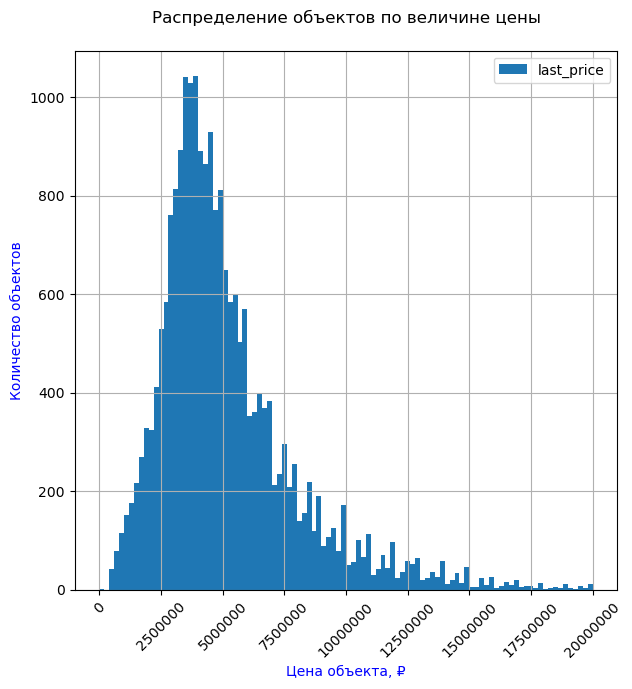

In [191]:
data.plot(y = 'last_price', kind = 'hist', bins = 100, grid=True, figsize = (7,7), range = (1,20000000))
plt.xlabel("Цена объекта, ₽", color='blue')
plt.ylabel("Количество объектов", color='blue')
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.title("Распределение объектов по величине цены", pad='20.0');

Гистограмма соответствует нормальному распределению дунных. Построим диаграмму размаха для столбца `last_price`

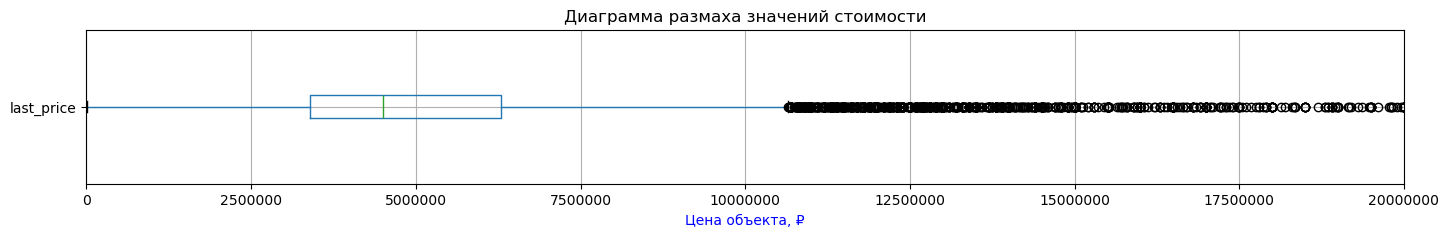

In [192]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['last_price']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха значений стоимости')
ax.set_xlim(0, 20000000)
plt.ticklabel_format(style='plain',axis='x')
plt.xlabel("Цена объекта, ₽", color='blue');

Нормальные значения стоимости объекта лежат в интервале от 0 до 10 100 000 &#8381;. Отсеим данные, непопадающие в этот интервал:

In [193]:
data = data.query('last_price<11000000')

**Вывод**: Выборка цен соответствует нормальному распределению с пиком в медианном значении 4 650 000 &#8381;. С помощью диаграммы размаха были определены границы нормальных значений: 0 &ndash; 10 100 000 &#8381; (округлили до 11 000 000 &#8381; чтобы потерять не слишком большой объем данных).

##### Количество комнат (`rooms`)

In [194]:
data['rooms'].describe()

count    20782.000000
mean         1.909537
std          0.885645
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64

Минимальное значение выборки &mdash; 0 комнат. Об этом значении я говорила в предобработке данных (все они &mdash; студии и объекты с открытой планировкой). В данный момент такие квартиры относятся к отдельным категориям и количество комнат для них не указывается. Чтобы отделить эти объекты от n-комнатных квартир, заполним их значения `rooms` нулями.

In [195]:
data.loc[(data['studio'] == True) | (data['open_plan'] == True), 'rooms'] = 0

Посмтрои гистограмму столбца `rooms`.

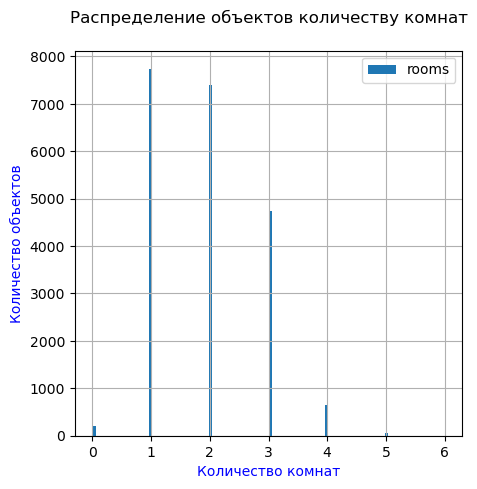

In [196]:
data.plot(y = 'rooms', kind = 'hist', bins = 100, grid=True, figsize = (5,5), range = (0,6))
plt.xlabel("Количество комнат", color='blue')
plt.ylabel("Количество объектов", color='blue')
plt.title("Распределение объектов количеству комнат", pad='20.0');

**Вывод**: Наибольшее число объектов в датафрейме — **однокомнатные, двухкомнатные и трёхкомнатные квартиры**. Однокомнатные квартиры популярнее по ряду причин:
1. Цена. Такие квартиры доступнее для одиноких людей и людям в гражданском браке.
2. Рентабельность. &laquo;Однушки&raquo; часто покупают с целью продать подороже, а также для сдачи в наём. 

##### Высота потолков (`ceiling_height`)

In [197]:
data['ceiling_height'].describe()

count    20782.000000
mean         2.694579
std          0.778469
min          1.000000
25%          2.600000
50%          2.650000
75%          2.670000
max         32.000000
Name: ceiling_height, dtype: float64

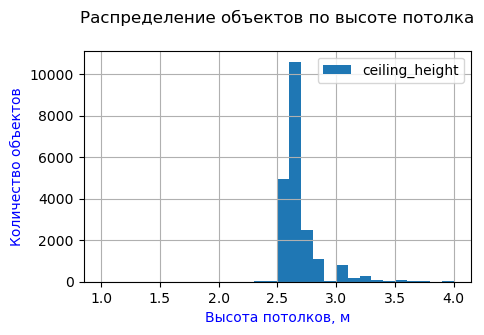

In [198]:
data.plot(y = 'ceiling_height', kind = 'hist', bins = 30, grid=True, figsize = (5,3), range = (1,4))
plt.xlabel("Высота потолков, м", color='blue')
plt.ylabel("Количество объектов", color='blue')
plt.title("Распределение объектов по высоте потолка", pad='20.0');

Минимальное значение в выборке &mdash; 1 м, a максимальное &mdash; 32 м. Кажется, в данные закралась ошибка. Стандартная высота потолков в России:

- «сталинки» — от 3 до 3,6 м;
- «хрущёвки» — 2,5 м, реже — 2,7 м;
- «брежневки» — 2,6–2,7 м;
- панельные и блочные дома — 2,5–2,7 м.

Однако, существуют некоторые объекты с высотой потолков до 6 м (с заделом под антресольный этаж).  


Проверим, есть ли в столбце значения > 6 м.

In [199]:
data.query('ceiling_height > 6')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,one_sq_meter_price,first_day_exposition_week_day,first_day_exposition_month,first_day_exposition_year,floor_type,cityCenters_nearest_km,living_area_share,median
720,14,2900000,75.0,2018-11-12,3,32.0,3,53.0,2,False,...,NaN,0,38666.67,0,2018-11-01,2018,другой,NaN,0.706667,0.634921
2157,5,3950000,42.0,2017-03-26,3,25.0,5,30.0,2,False,...,NaN,0,94047.62,6,2017-03-01,2017,другой,14.0,0.714286,0.634921
3625,14,5600000,67.0,2016-11-11,3,8.0,16,41.0,1,False,...,NaN,474,83582.09,4,2016-11-01,2016,первый,11.0,0.611940,0.634921
4005,15,6700000,92.9,2019-02-19,3,20.0,17,53.2,14,False,...,NaN,0,72120.56,1,2019-02-01,2019,другой,15.0,0.572659,0.634921
4100,1,3900000,56.0,2017-12-22,3,27.0,5,33.0,4,False,...,NaN,73,69642.86,4,2017-12-01,2017,другой,16.0,0.589286,0.634921
6544,3,1400000,30.0,2018-03-16,1,8.0,5,15.3,2,False,...,NaN,125,46666.67,4,2018-03-01,2018,другой,NaN,0.510000,0.481690
7123,0,3850000,30.5,2018-10-03,1,24.0,5,19.5,1,True,...,578.0,7,126229.51,2,2018-10-01,2018,первый,8.0,0.639344,0.481690
7405,20,5650000,45.0,2018-08-15,1,8.3,16,19.3,14,False,...,613.0,14,125555.56,2,2018-08-01,2018,другой,11.0,0.428889,0.481690
9239,0,1950000,37.0,2019-03-20,1,25.0,5,17.0,4,False,...,NaN,18,52702.70,2,2019-03-01,2019,другой,NaN,0.459459,0.481690
10267,9,1700000,35.0,2015-12-04,1,25.0,5,20.0,2,False,...,NaN,206,48571.43,4,2015-12-01,2015,другой,NaN,0.571429,0.481690


Есть несколько значений между 20 и 60 метрами: скорее всего, при заполнении формы пользователь проставил запятую в неправильном месте. Устраним эти аномалии, поделив значения > 20 на 10.

In [200]:
def ceil_height_correct(row):
    """
    Возвращает высоту потолка:
    - / 10, если величина больше 20, и меньше 60;
    - неизменно, если иначе.
    """
    if 20 <= row['ceiling_height'] < 60:
        return row['ceiling_height'] / 10
    return row['ceiling_height']

In [201]:
data['ceiling_height'] = data.apply(ceil_height_correct, axis=1) 

Данные, не попавшие в диапазон от 2 до 8 м, предлагается удалить, как аномальные.

In [202]:
data = data.query('ceiling_height > 2 and ceiling_height <= 8')

**Вывод**: в столбце `ctiling_height` были обнаружены аномальные значения (1 м, 100 м). Были скорректированы значения, в которых можно было опознать ошибку (26.5, 27, 32 м). Медианное значение выборки &mdash; **2.65 м**, соответствует типовой высоте потолка в квартирах России.

##### Тип этажа квартиры (`floor_type`)

In [203]:
data.groupby('floor_type')['floor_type'].count()

floor_type
другой       15212
первый        2701
последний     2852
Name: floor_type, dtype: int64

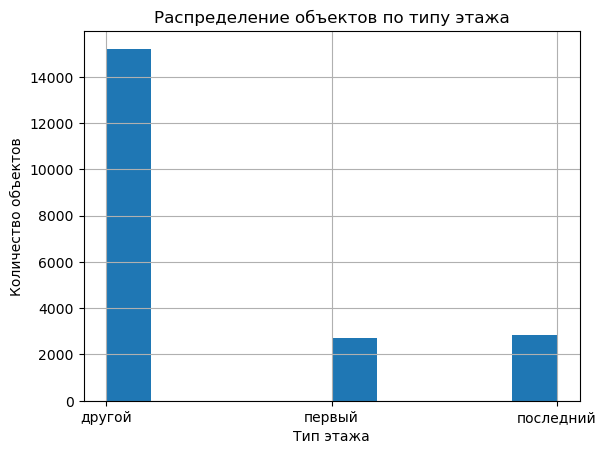

In [204]:
data['floor_type'].hist()
plt.xlabel("Тип этажа")
plt.ylabel("Количество объектов")
plt.title("Распределение объектов по типу этажа");

**Вывод:** 73% квартир в таблице расположено не на первом и не на последнем этаже &mdash; это связано с этажностью строительства. Первый и последний этаж &mdash; это лишь по одному этажу, а группа другой включает в себя все этажи, кроме первого и последнего. Доля квартир на первом этаже примерно равна доле квартир на последнем этаже. 

##### Общее количество этажей в доме (`floors_total`)

In [205]:
data['floors_total'].describe()

count    20765.000000
mean        10.778088
std          6.620981
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Согласно рейтингу самых высоких жилых домов [Санкт-Петербурга](https://dominfospb.ru/doma-po-etazham) и [Ленинградской области](https://lenobldoma.ru/doma-po-etazham), `floors_total` не может превышать 36 этажей. Поэтому отметём все объекты выше данной отметки.

In [206]:
data = data.query('floors_total<=36')

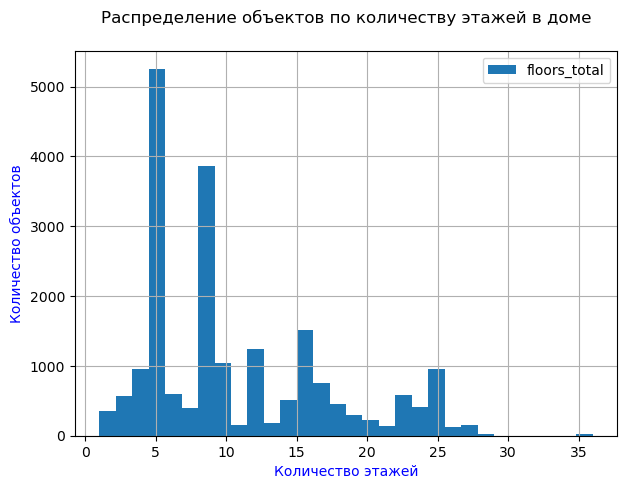

In [207]:
data.plot(y = 'floors_total', kind = 'hist', bins = 30, grid=True, figsize = (7,5), range = (1,36))
plt.xlabel("Количество этажей", color='blue')
plt.ylabel("Количество объектов", color='blue')
plt.title("Распределение объектов по количеству этажей в доме", pad='20.0');

**Вывод**: на гистограмме хорошо заметны несколько пиков (5, 9, 12 и 16 этажей). Эти значения соответствуют самой расространённой этажности домов в России.

##### Расстояние до центра города в метрах (`cityCenters_nearest`)

In [208]:
data['cityCenters_nearest'].describe()

count    15455.000000
mean     15095.169395
std       8485.327315
min        208.000000
25%      10760.000000
50%      13717.000000
75%      16758.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

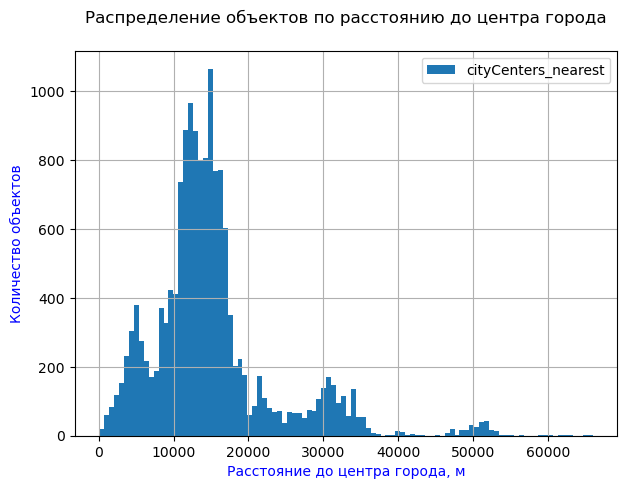

In [209]:
data.plot(y = 'cityCenters_nearest', kind = 'hist', bins = 100, grid=True, figsize = (7,5), range = (100,66000))
plt.xlabel("Расстояние до центра города, м", color='blue')
plt.ylabel("Количество объектов", color='blue')
plt.title("Распределение объектов по расстоянию до центра города", pad='20.0');

**Вывод**: Наибольшее количество объектов расположено на расстоянии 10-20 км от центра города (предположу, что квартиры, расположенные в пределах КАД относятся к Санкт-Петербургу &mdash; рекордсмену по количеству объявлений) + примешиваются объявления из ближайших городов-спутников. К ним же относятся небольшие колебания на гистограмме в значениях 22 км, 31 км, 52 км.

##### Расстояние до ближайшего парка (`parks_nearest`)

In [210]:
data['parks_nearest'].describe()

count    6385.000000
mean      486.783712
std       321.727504
min         1.000000
25%       289.000000
50%       456.000000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64

Максимальное значение выборки составляет 3190 м &mdash; эти данные не очень полезны, с учётом того, что учитываются только парки на расстоянии меньше 3 км. Уберём строчки со значениями > 3000 м.

In [211]:
# Узнаем, какие строчки содержат в столбце parks_nearest значения > 3000
data.query('parks_nearest > 3000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,one_sq_meter_price,first_day_exposition_week_day,first_day_exposition_month,first_day_exposition_year,floor_type,cityCenters_nearest_km,living_area_share,median
9114,9,3000000,31.1,2017-03-21,1,2.65,5,17.7,2,False,...,431.0,234,96463.02,1,2017-03-01,2017,другой,10.0,0.569132,0.481690
11942,9,3900000,30.5,2018-02-22,1,2.60,5,16.5,1,False,...,431.0,176,127868.85,3,2018-02-01,2018,первый,10.0,0.540984,0.481690
13935,3,7500000,70.0,2017-07-11,2,2.65,18,37.0,13,False,...,264.0,4,107142.86,1,2017-07-01,2017,другой,10.0,0.528571,0.584906


In [212]:
data = data.query('parks_nearest < 3000 or parks_nearest.isna()')

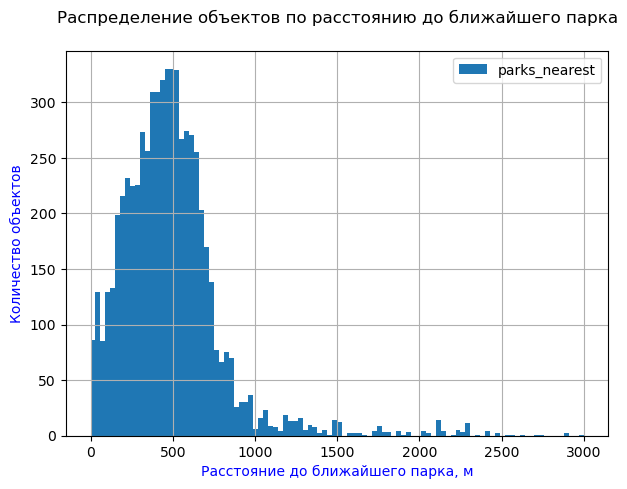

In [213]:
data.plot(y = 'parks_nearest', kind = 'hist', bins = 100, grid=True, figsize = (7,5), range = (0,3000))

plt.xlabel("Расстояние до ближайшего парка, м", color='blue')
plt.ylabel("Количество объектов", color='blue')
plt.title("Распределение объектов по расстоянию до ближайшего парка", pad='20.0');

**Вывод**: Две трети объектов не имеют парков в радиусе 3 км. Однако большинство квартир с парками в округе имеют таковой в 10 минутах ходьбы (от 0 до 1 км).

### Как быстро продавались квартиры (столбец `days_exposition`)

Определим основные описательные характеристики выборки и построим гистограмму.

In [214]:
data['days_exposition'].describe()

count    20760.000000
mean       150.883478
std        203.902834
min          0.000000
25%         24.000000
50%         71.000000
75%        191.000000
max       1580.000000
Name: days_exposition, dtype: float64

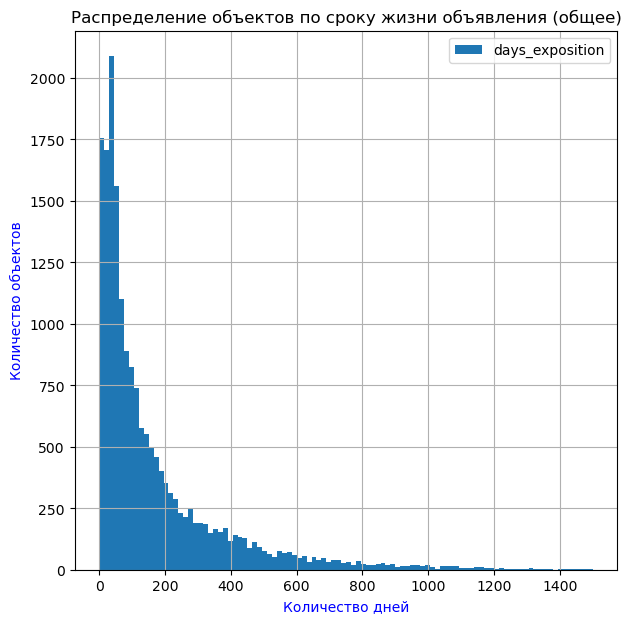

In [215]:
data.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid=True, figsize=(7,7), range=(1,1500))
plt.xlabel("Количество дней", color='blue')
plt.ylabel("Количество объектов", color='blue')
plt.title("Распределение объектов по сроку жизни объявления (общее)");

Кажется, в пределах от 0 до 100 дней есть какие-то пики. Взглянем на гистограмму поближе:

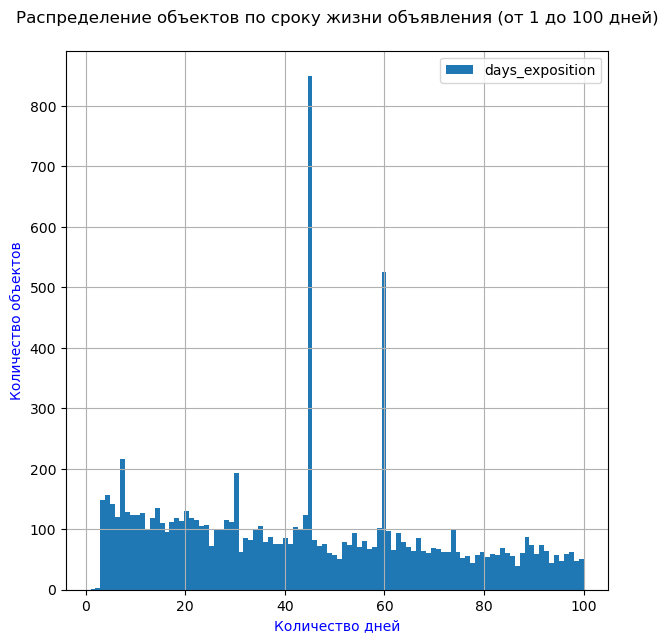

In [216]:
data.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid=True, figsize=(7,7), range=(1,100))
plt.xlabel("Количество дней", color='blue')
plt.ylabel("Количество объектов", color='blue')
plt.title("Распределение объектов по сроку жизни объявления (от 1 до 100 дней)", pad='20.0');

<a id='section_days'></a>
На гистограмме видны 5 пиков: у значений 7, 30, 45, 60 дней (0 дней в расчёт брать не будем). При ознакомлении с [правлами размещения](https://yandex.ru/support/realty/owner/home/add-ads-housing.html) объявления видим, что в разделе о сроках публикации указано, что срок размещения объявления ограничен (см. раздел сроки размещения). Часть объектов могла быть продана как раз в день автоснятия или за какое-то время до него (пользователь мог забыть снять объявление), а могла быть не продана вообще. Эти дни можем отнести к аномальным и дальнейшие выводы о том, сколько занимает продажа, будем делать на основе отфильтрованного датафрейма.

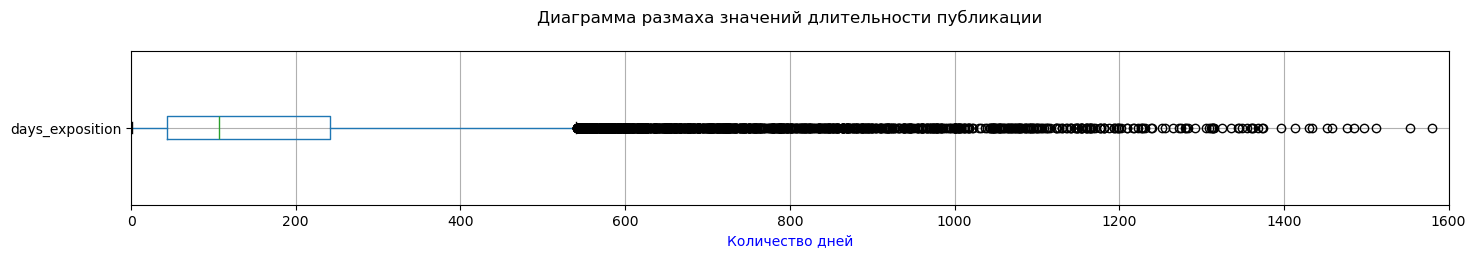

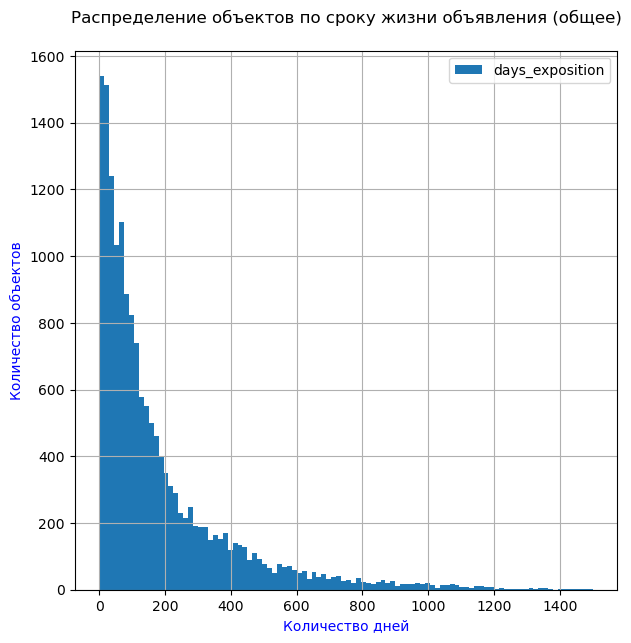

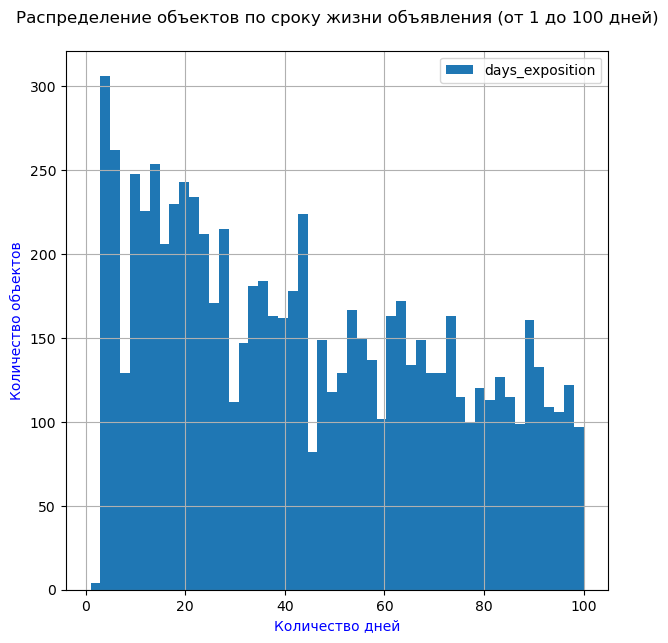

In [217]:
#очистим данные от объявлений, ушедших из публикации через 7, 30, 45 и 60 дней
days_list = [0, 7, 30, 45, 60]
data_stat = data.query('days_exposition not in @days_list')
#на основе этих данных построим диаграмму размаха, чтобы выяснить, какие данные попадают в нормальное распредение

fig, ax = plt.subplots(figsize = (17,2))
ax = data_stat[['days_exposition']].boxplot(vert = False, ax = ax)
ax.set_title('Диаграмма размаха значений длительности публикации', pad='20.0')
ax.set_xlim(0, 1600)
plt.xlabel("Количество дней", color='blue');

#перестроим диаграммы для отфильтрованных данных
data_stat.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid=True, figsize=(7,7), range=(1,1500))
plt.xlabel("Количество дней", color='blue');
plt.ylabel("Количество объектов", color='blue')
plt.title("Распределение объектов по сроку жизни объявления (общее)", pad='20.0');
data_stat.plot(y = 'days_exposition', kind = 'hist', bins = 50, grid=True, figsize=(7,7), range=(1,100))
plt.xlabel("Количество дней", color='blue');
plt.ylabel("Количество объектов", color='blue')
plt.title("Распределение объектов по сроку жизни объявления (от 1 до 100 дней)", pad='20.0');


Видно, как гистограммы &laquo;разгладились&raquo; и стали похожи на распределение Пуассона. Пересчитаем основные характеристики для столбца `days_exposition` (для отфильтрованных данных)

In [218]:
data_stat['days_exposition'].describe()

count    16455.000000
mean       185.677727
std        215.566924
min          1.000000
25%         43.000000
50%        107.000000
75%        242.000000
max       1580.000000
Name: days_exposition, dtype: float64

Теперь медиана выборки &mdash; 107 дней (против &laquo;неотфильтрованных&raquo; 71 дней). Границы нормальных значений пролегают между 1 и 541 днями <nobr>(~ 242 + (242 &ndash; 43) × 1.5).</nobr> 

**Вывод**: чаще всего объекты продаются в срок **до 107 дней**. Сделки, заключённые **до 43 дней** можно считать быстрыми. К аномально долгим продажам можем отнести объекты, пробывшие на сайте **дольше 541 дня**.

### Определим факторы, которые больше всего влияют на общую (полную) стоимость объекта

Так как в датафрейме много объектов с одинаковой площадью, но при этом цена объекта может различаться, соберём данные в сводную таблицу.

#### Общая площадь объекта (`total_area`)

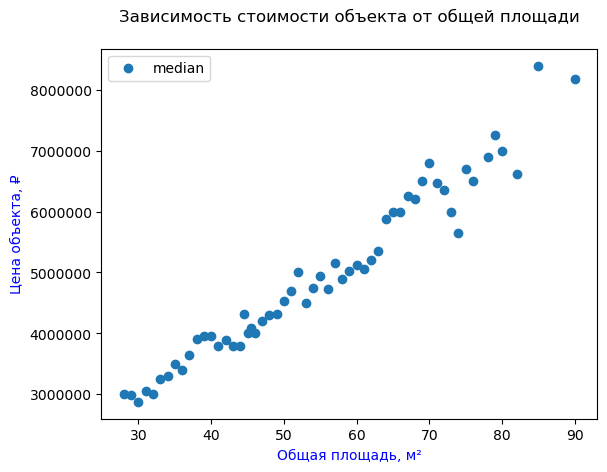

In [219]:
#так как есть много объектов с одинаковой площадью, соберём данные в сводную таблицу, где 
#строки — общая площадь объекта, а в столбце — медианные значения стоимости недвижимости
total_area_pivot_table = data.pivot_table(index = 'total_area', values = 'last_price', aggfunc = ['median','count'])
total_area_pivot_table.columns = ['median','count']

total_area_pivot_table.query('count>50').plot(y = 'median', style = 'o')
plt.ticklabel_format(style='plain',axis='y')
plt.xlabel("Общая площадь, м²", color='blue');
plt.ylabel("Цена объекта, ₽", color='blue')
plt.title("Зависимость стоимости объекта от общей площади", pad='20.0');

Вычислим коэффициент корреляции между `last_price` и `total_area`.

In [220]:
data['last_price'].corr(data_stat['total_area'])

0.6982610394170307

**Чем больше общая площадь &mdash; тем выше стоимость объекта**.

#### Общая площадь объекта (`living_area`)

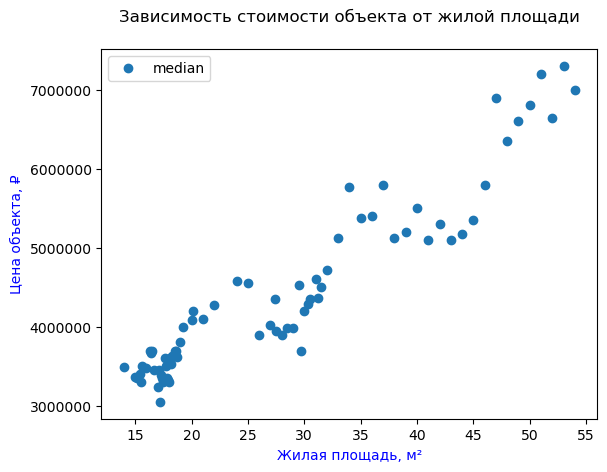

In [221]:
living_area_pivot_table = data.pivot_table(index = 'living_area', values = 'last_price', aggfunc = ['median','count'])
living_area_pivot_table.columns = ['median','count']

living_area_pivot_table.query('count>50').plot(y = 'median', style = 'o')
plt.ticklabel_format(style='plain',axis='y')
plt.xlabel("Жилая площадь, м²", color='blue')
plt.ylabel("Цена объекта, ₽", color='blue')
plt.title("Зависимость стоимости объекта от жилой площади", pad='20.0');


In [222]:
data['last_price'].corr(data_stat['living_area'])

0.556437693026337

Существует зависимость между `last_price` и `living_area`, однако не такая сильная, как для `total_area` (коэффициент корреляции ниже).   
**Чем больше жилая площадь &mdash; тем выше стоимость объекта**.

#### Площадь кухни (`kitchen_area`)

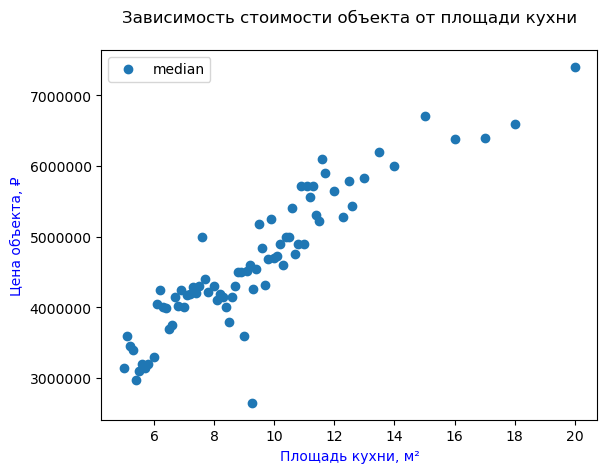

In [223]:
kitchen_area_pivot_table = data.pivot_table(index = 'kitchen_area', values = 'last_price', aggfunc = ['median','count'])
kitchen_area_pivot_table.columns = ['median','count']

kitchen_area_pivot_table.query('count>50').plot(y = 'median', style = 'o')
plt.ticklabel_format(style='plain',axis='y')
plt.xlabel("Площадь кухни, м²", color='blue');
plt.ylabel("Цена объекта, ₽", color='blue')
plt.title("Зависимость стоимости объекта от площади кухни", pad='20.0');

In [224]:
data['last_price'].corr(data_stat['kitchen_area'])

0.45847569294585877

Существует зависимость между `last_price` и `kitchen_area`, однако не такая сильная, как для `total_area` и `living_area` (коэффициент корреляции ниже).   
**Чем больше площадь кухни &mdash; тем выше стоимость объекта**.

#### Количество комнат (`rooms`)

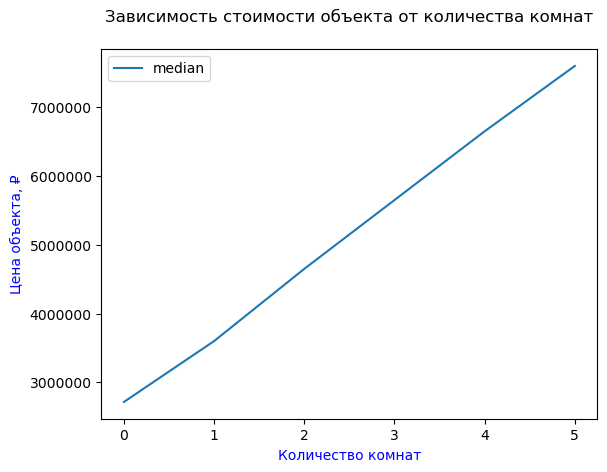

In [225]:
rooms_pivot_table = data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = ['median','count'])
rooms_pivot_table.columns = ['median', 'count']

#не будем учитывать "единичные" объекты с большим количеством комнат, чтобы корректно представить зависимость
rooms_pivot_table.query('count > 50').plot(y = 'median')
plt.ticklabel_format(style='plain',axis='y')
plt.xlabel("Количество комнат", color='blue');
plt.ylabel("Цена объекта, ₽", color='blue')
plt.title("Зависимость стоимости объекта от количества комнат", pad='20.0');

In [226]:
data['last_price'].corr(data_stat['rooms'])

0.44476933829569415

**Чем больше количество комнат, тем выше цена**. Однако можно сказать, что **количество комнат влияет на цену меньше**, нежели площадь объекта (общая, жилая, кухня).

#### Этаж, на котором расположена квартира (первый, последний, другой) (`floor_type`)

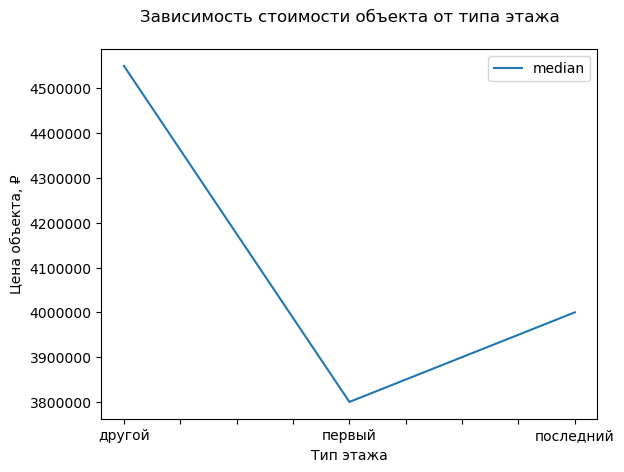

In [227]:
floor_type_pivot_table = data.pivot_table(index = 'floor_type', values = 'last_price', aggfunc = ['median', 'count','mean'])
floor_type_pivot_table.columns = ['median', 'count', 'mean']

floor_type_pivot_table.plot(y = 'median')
plt.ticklabel_format(style='plain',axis='y')
plt.xlabel("Тип этажа");
plt.ylabel("Цена объекта, ₽")
plt.title("Зависимость стоимости объекта от типа этажа", pad='20.0');

In [228]:
floor_type_pivot_table

,median,count,mean
floor_type,,,
другой,4550000.0,15208,4.940095e+06
первый,3800000.0,2700,4.090366e+06
последний,4000000.0,2852,4.358170e+06


По виду таблицы и графику, можно сказать, что **в среднем** самые дорогие &mdash; объекты, расположенные на &laquo;других&raquo; этажах (не первый и не последний). А самые дешёвые &mdash; на первом. Отдельного внимания заслуживают квартиры, расположенные на последних этажах &mdash; здесь рекоммендуется учитывать год постройки и класс жилья. На последнем этаже может располагаться квартира, переделанная из чердачного помещения, или элитный пентхаус :)

#### Дата размещения (`first_day_exposition_week_day`, `first_day_exposition_month`, `first_day_exposition_year`)

##### День недели `first_day_exposition_week_day`

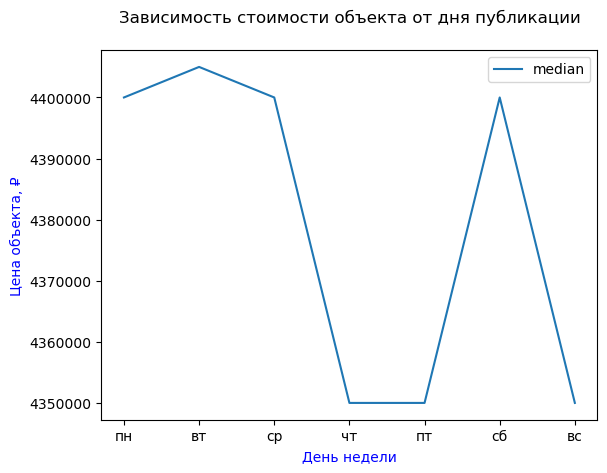

In [229]:
first_day_exposition_pivot_table = data.pivot_table(
    index = 'first_day_exposition_week_day',
    values = 'last_price', 
    aggfunc = 'median')
first_day_exposition_pivot_table.columns = ['median']

first_day_exposition_pivot_table.plot(y = 'median')
plt.ticklabel_format(style='plain',axis='y')
plt.xlabel("День недели", color='blue');
plt.ylabel("Цена объекта, ₽", color='blue')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'])
plt.title("Зависимость стоимости объекта от дня публикации", pad='20.0');

На графике зафиксировано небольшое колебание медианных значений (~50 000 &#8381;). Можно сказать, что нет связи между днём недели публикации объявления и стоимостью квартиры.

##### Месяц (`first_day_exposition_month`)

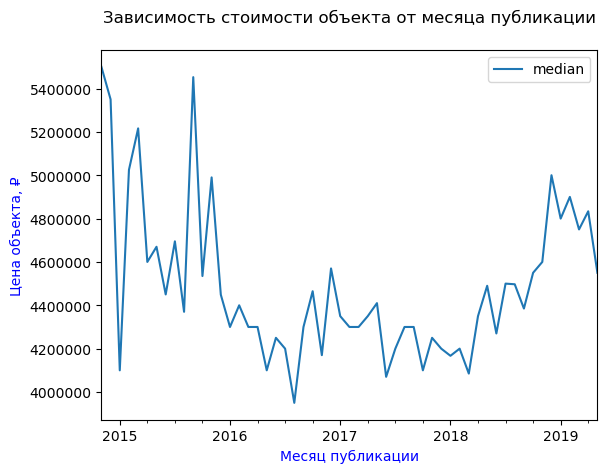

In [230]:
first_day_exposition_pivot_table = data.pivot_table(
    index = 'first_day_exposition_month',
    values = 'last_price', 
    aggfunc = 'median')
first_day_exposition_pivot_table.columns = ['median']

first_day_exposition_pivot_table.plot(y = 'median')
plt.ticklabel_format(style='plain',axis='y')
plt.ylabel("Цена объекта, ₽", color='blue')
plt.xlabel("Месяц публикации", color='blue');
plt.title("Зависимость стоимости объекта от месяца публикации", pad='20.0');

Самые низкие цены на квартиры были в июле 2016 года. Самые высокие &mdash; в конце ноября 2014 года и в августе 2015 года. В среднем цены идут на подъём с середины 2016 и до конца 2019 года.

##### Год (`first_day_exposition_year`)

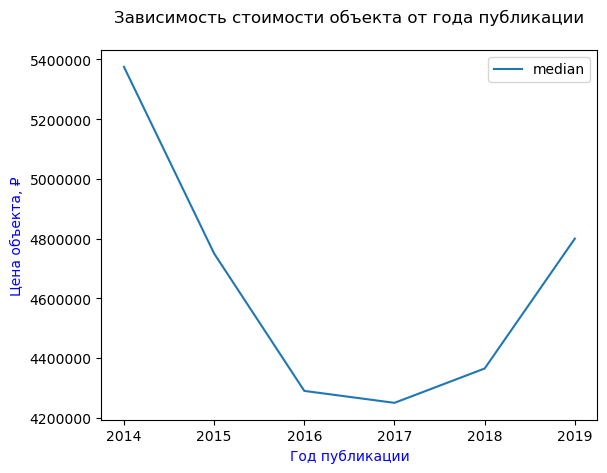

In [231]:
first_day_exposition_pivot_table = data.pivot_table(
    index = 'first_day_exposition_year',
    values = 'last_price', 
    aggfunc = 'median')
first_day_exposition_pivot_table.columns = ['median']

first_day_exposition_pivot_table.plot(y = 'median')
plt.ticklabel_format(style='plain',axis='y')
plt.ylabel("Цена объекта, ₽", color='blue')
plt.xlabel("Год публикации", color='blue');
plt.title("Зависимость стоимости объекта от года публикации", pad='20.0');

На графике можем наблюдать падение цен с 2014 до 2017 года, но, хотелось бы увидеть данные за 2013 год. _Возможно_, в 2014 был резкий скачок цен, связанный с валютными колебаниями. В связи с экономическим кризисом, спрос на недвижимость резко упал. Однако с 2017 года цены начали расти: это объясняется отложенным спросом населения (с 2014 года).

### Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений 

In [232]:
one_sq_meter_price_pivot_table = data.pivot_table(index='locality_name', values='one_sq_meter_price', aggfunc=['count','median'])
one_sq_meter_price_pivot_table.columns = ['count','median']
one_sq_meter_price_pivot_table = one_sq_meter_price_pivot_table.sort_values(by='count', ascending=False).head(10)
one_sq_meter_price_pivot_table

,count,median
locality_name,,
Санкт-Петербург,13144,101619.460
посёлок Мурино,530,85452.420
посёлок Шушары,432,76747.970
Всеволожск,383,65789.470
Колпино,333,74725.270
Пушкин,331,98437.500
посёлок Парголово,324,91780.225
Гатчина,293,67796.610
деревня Кудрово,293,91860.470


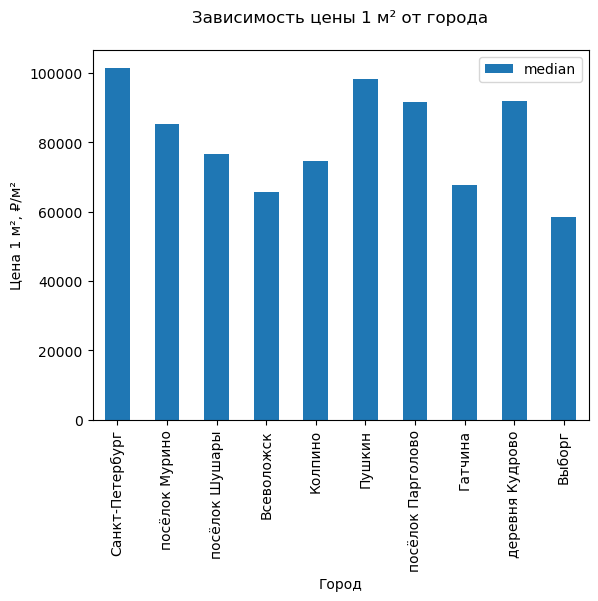

In [233]:
one_sq_meter_price_pivot_table.plot(y = 'median', kind='bar')
plt.ylabel("Цена 1 м², ₽/м²")
plt.xlabel("Город");
plt.title("Зависимость цены 1 м² от города", pad='20.0');

Самая высокая средняя стоимость квадратного метра &mdash; в Санкт-Петербурге (101 619 &#8381;/м<sup>2</sup>), самая низкая &mdash; в Выборге (58 357 &#8381;/м<sup>2</sup>).

### Средняя стоимость квартир на разном удалении от города (для Санкт-Петербурга)

,median,count
cityCenters_nearest_km,,
0.0,7200000.0,8
1.0,8100000.0,84
2.0,7950000.0,159
3.0,6999000.0,225
4.0,7290000.0,403
5.0,7251770.0,520
6.0,6737800.0,388
7.0,6235000.0,272
8.0,6150000.0,445


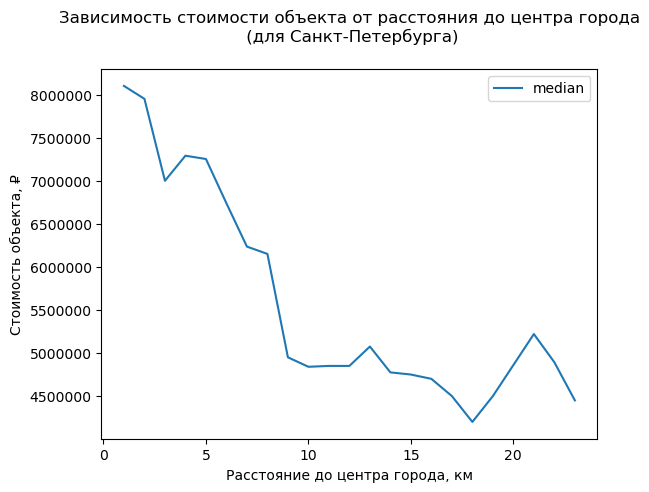

In [234]:
spb_pivot_table = (
    data
    .query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc=['median','count'])
)
spb_pivot_table.columns = ['median', 'count']
spb_pivot_table.query('count > 50').plot(y = 'median')
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel("Стоимость объекта, ₽")
plt.xlabel("Расстояние до центра города, км");
plt.title("Зависимость стоимости объекта от расстояния до центра города\n (для Санкт-Петербурга)", pad='20.0');
spb_pivot_table

Как и ожидалось, самые дорогие квартиры находятся в центре города. В радиусе 3-4 км расположен исторический центр Санкт-Петербурга, большая часть строений достаточно почтенного возраста (можно наглядно посмотреть на этой [карте](https://kontikimaps.ru/how-old/saint-p)), новостроек тут очень мало. Несмотря на всю притягательность &laquo;старого фонда&raquo; в центре, он имеет ряд минусов: если дом входит в реестр объектов культурного наследия, собственник может столкнуться с ограничениями со стороны Министерства Культуры и управляющей компании (необходимо дополнительно согласовывать ремонтные работы, если таковые потребуются), да и в целом старый дом требует больше вложений. За пределами исторического центра (на графике &mdash; пик 5-6 км) старых зданий гораздо меньше, но при этом расстояние от центра всё ещё достаточно малое, что делает квартиры привлекательными для потенциальных покупателей.

Небольшие пики в 13 и 22 км от центра могут быть объяснены примешиванием объявлений из городов-спутников.

<a id='step_5'></a>
## Вывод

<a id="fast-sells"></a>
В ходе работы над проектом был обработан датафрейм с архивными объявлениями: 
1. Устранены пропущенные значения там, где это возможно, а также неявные дубликаты в названиях населённых пунктов.
2. Скорректированы типы данных для удобсва работы с информацией.  
3. Вычислены и добавлены в таблицу:  
а) цена квадратного метра;  
б) день недели/месяц/год публикации объявления;  
в) тип этажа квартиры;  
г) расстояние от центра города (в км)
4. Изучены и описаны параметры (выявлены и устранены аномалии):  
а) общая площадь;  
б) жилая площадь;  
в) площадь кухни;  
г) цена объекта;  
д) высота потолков;  
е) тип этажа;  
ж) общее количество этажей в доме;  
з) расстояние до центра города в метрах;  
и) расстояние до ближайшего парка.    
5. При исследовании данных было установлено:  
а) Многие объявления автоматически снимаются с публикации по истечению срока публикации &mdash; объявления, пропавшие в эти дни нельзя учитывать при определении сроков продаж квартир, поэтому при расчёте границ нормального распределения эти данные не учитывались. При помощи диаграммы размаха было установлено, что можно считать сделку быстрой, если она заключена в срок до 43 дней и необычно долгой по прошествии 541 дня.  
б) На стоимость объекта больше всего оказывают влияние общая площадь объекта (чем больше квартира, тем она дороже), жилая площадь, количество комнат (чем больше комнат, тем дороже квартира), а также этаж объекта (не первый) и близость к центру (чем ближе к центру, тем  дороже).   
в) Также следует учитывать стоимость квартир в контексте экономической ситуации в стране (с учётом ключевых ставок по ипотеке, валютного курса, прочих факторов, связанных с экономикой): на графике, показывающем зависимость средней стоимости недвижимости по годам, можно увидеть резкое падение (с 2014 по 2017 год) и небольшой рост (с 2017 по 2019).   